In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Data Transformations

We define the data transformations for the training and validation datasets, including resizing and data augmentation techniques for the training data.

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

## Load Datasets

We load the training and validation datasets using `ImageFolder`.


In [4]:
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/sapienza-dl2425-challenge/dl2425_challenge_dataset/train', 
    transform=train_transforms
)
val_dataset = datasets.ImageFolder(
    root='/kaggle/input/sapienza-dl2425-challenge/dl2425_challenge_dataset/val', 
    transform=val_transforms
)

In [5]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Hyperparameters and Weight Decay Values

We define the number of epochs and a list of weight decay values to test.


In [6]:
# Number of epochs
num_epochs = 10

# Define a list of weight decay values to test
weight_decay_values = [0, 1e-6, 1e-5, 1e-3]

# Dictionary to store results for each weight decay
results = {}

## Training and Validation Loop

We iterate over each weight decay value, training a new model each time and evaluating its performance on the validation set.

In [7]:
for wd in weight_decay_values:
    print(f"\nTesting weight decay: {wd}\n")
    
    # Initialize the model
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)
    model = model.to(device)
    
    # Define the loss function and optimizer with the current weight decay
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=wd)
    
    # Initialize lists to store losses for this weight decay
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
    
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
    
            optimizer.zero_grad()
    
            outputs = model(images)
            loss = criterion(outputs, labels)
    
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item() * images.size(0)
    
        epoch_loss = running_loss / len(train_dataset)
        training_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')
    
        # Validation step
        model.eval()
        val_running_loss = 0.0
        correct_predictions = 0
    
        # Initialize lists to store predictions and labels
        all_preds = []
        all_labels = []
    
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.float().unsqueeze(1).to(device)
    
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
    
                val_running_loss += val_loss.item() * val_images.size(0)
    
                # Calculate accuracy
                preds = torch.sigmoid(val_outputs) >= 0.5
                correct_predictions += torch.sum(preds == val_labels.byte())
    
                # Collect predictions and labels
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(val_labels.cpu().numpy())
    
        val_epoch_loss = val_running_loss / len(val_dataset)
        validation_losses.append(val_epoch_loss)
        val_accuracy = correct_predictions.double() / len(val_dataset)
    
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_val_accuracy = val_accuracy.item()
            torch.save(model.state_dict(), f'best_model_wd_{wd}.pth')
            print(f"Saved Best Model at Epoch {epoch+1} with weight decay {wd}")
    
        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    # Store the results for this weight decay value
    results[wd] = {
        'best_val_loss': best_val_loss,
        'val_accuracy': best_val_accuracy,
        'training_losses': training_losses,
        'validation_losses': validation_losses,
        'all_preds': all_preds,
        'all_labels': all_labels,
    }



Testing weight decay: 0



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


Epoch 1/10, Training Loss: 0.5486
Saved Best Model at Epoch 1 with weight decay 0
Validation Loss: 0.4111, Validation Accuracy: 0.8417
Epoch 2/10, Training Loss: 0.3444
Saved Best Model at Epoch 2 with weight decay 0
Validation Loss: 0.2654, Validation Accuracy: 0.9292
Epoch 3/10, Training Loss: 0.2371
Saved Best Model at Epoch 3 with weight decay 0
Validation Loss: 0.1885, Validation Accuracy: 0.9529
Epoch 4/10, Training Loss: 0.1827
Saved Best Model at Epoch 4 with weight decay 0
Validation Loss: 0.1476, Validation Accuracy: 0.9603
Epoch 5/10, Training Loss: 0.1520
Saved Best Model at Epoch 5 with weight decay 0
Validation Loss: 0.1208, Validation Accuracy: 0.9692
Epoch 6/10, Training Loss: 0.1306
Saved Best Model at Epoch 6 with weight decay 0
Validation Loss: 0.0997, Validation Accuracy: 0.9760
Epoch 7/10, Training Loss: 0.1159
Saved Best Model at Epoch 7 with weight decay 0
Validation Loss: 0.0902, Validation Accuracy: 0.9766
Epoch 8/10, Training Loss: 0.1028
Saved Best Model at E

## Evaluate Results

After training with all weight decay values, we determine the best one based on the lowest validation loss.

In [8]:
# After testing all weight decay values
best_wd = min(results, key=lambda k: results[k]['best_val_loss'])
print(f"\nBest weight decay value: {best_wd}")
print(f"Best Validation Loss: {results[best_wd]['best_val_loss']}")
print(f"Validation Accuracy: {results[best_wd]['val_accuracy']}")


Best weight decay value: 1e-05
Best Validation Loss: 0.06923268175123212
Validation Accuracy: 0.9817366228772829


## Visualizations and Confusion Matrix

For each weight decay value, we plot the training and validation losses and display the confusion matrix.


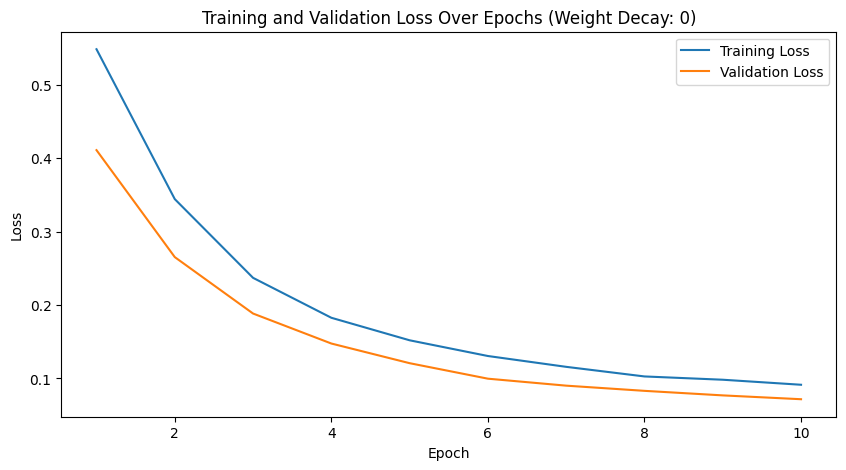

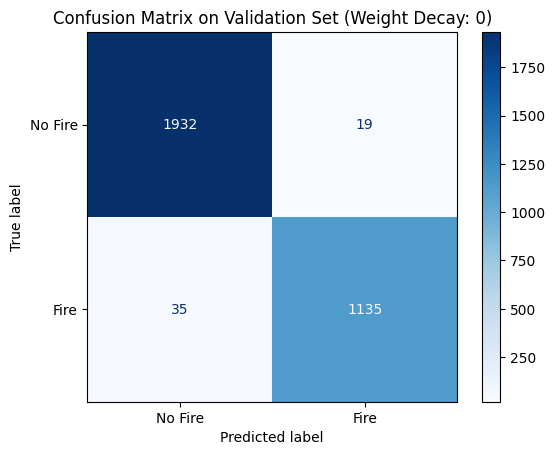

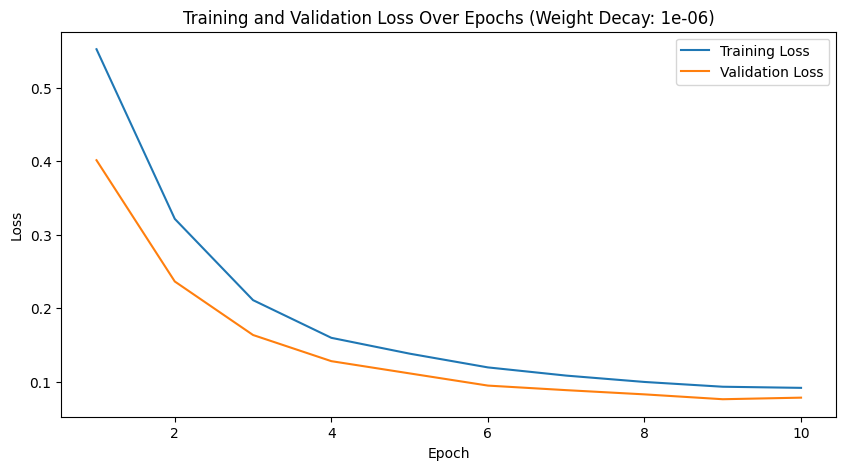

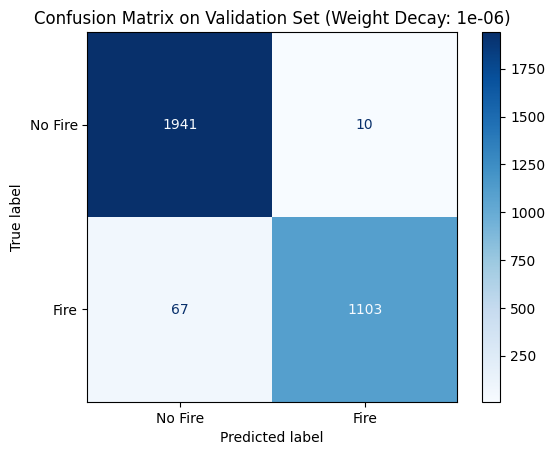

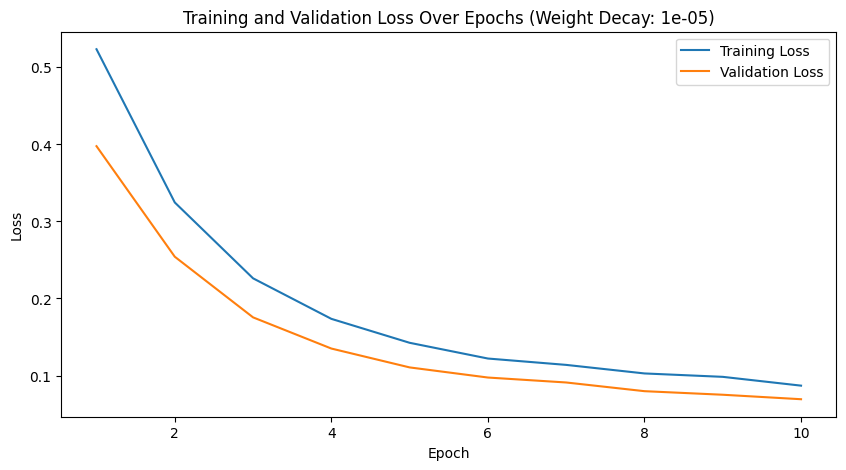

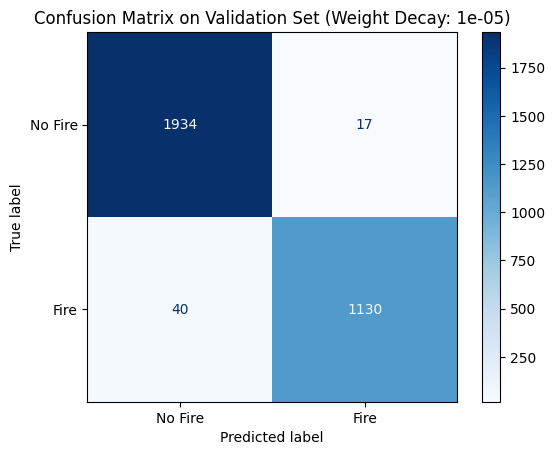

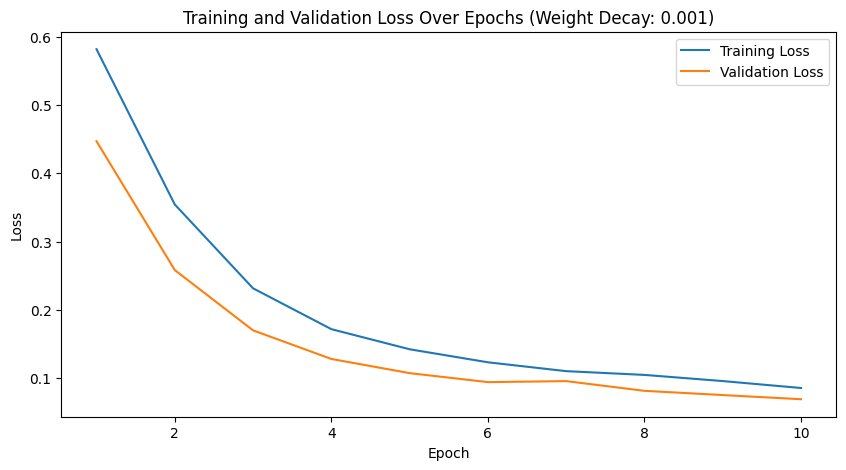

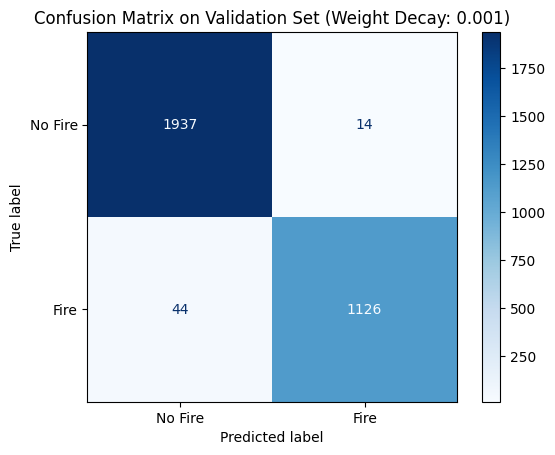

In [9]:
for wd in weight_decay_values:
    # Retrieve losses and predictions
    training_losses = results[wd]['training_losses']
    validation_losses = results[wd]['validation_losses']
    all_preds = results[wd]['all_preds']
    all_labels = results[wd]['all_labels']
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Over Epochs (Weight Decay: {wd})')
    plt.legend()
    plt.show()
    
    # Generate confusion matrix
    all_preds_np = np.array(all_preds).astype(int).flatten()
    all_labels_np = np.array(all_labels).astype(int).flatten()
    
    cm = confusion_matrix(all_labels_np, all_preds_np)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fire', 'Fire'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix on Validation Set (Weight Decay: {wd})')
    plt.show()

## Save the Best Model

We load the best model based on the lowest validation loss and save it for future use.

In [10]:
# Load and save the best model overall
best_model_path = f'best_model_wd_{best_wd}.pth'
best_model = models.resnet18(pretrained=True)
num_features = best_model.fc.in_features
best_model.fc = nn.Linear(num_features, 1)
best_model.load_state_dict(torch.load(best_model_path))
best_model = best_model.to(device)
torch.save(best_model.state_dict(), '/kaggle/working/fire_classification_best_model.pth')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_22/864957296.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details

# Conclusion

We tested multiple weight decay values and found that the best weight decay value is **`{best_wd}`**, which resulted in the lowest validation loss and a validation accuracy of **`{results[best_wd]['val_accuracy']:.4f}`**. The plots and confusion matrices provide insights into how weight decay affects model training and generalization.

**Next Steps:**

- Experiment with other hyperparameters like learning rate, batch size, and number of epochs.
- Implement techniques like early stopping or learning rate scheduling.
- Explore different architectures or fine-tune more layers of the pre-trained model.